# Notebook to visualize the results from LevSeq campaigns

Here we use the combined output from the campaigns and then visualize as heatmaps for various filters.

# Lineage analysis

In [1]:
import pandas as pd
import numpy as np
import Levenshtein
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
from sciutil import SciUtil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import AlignIO
import numpy as np
import re

u = SciUtil()

# Helper functions
# Sort rows by similarity (Hamming distance) to first row
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum(a != b for a, b in zip(seq1, seq2))
    
def get_hamming(df, parent_name, variant_name):
    parent = df[df['name'] == parent_name]['AA'].values[0]
    variant = df[df['name'] == variant_name]['AA'].values[0]
    # Since the same we can do hamming distance
    hamming_dist = 0
    variant_changes = []
    for i in range(0, len(parent)):
        if parent[i] != variant[i]:
            variant_changes.append(f'{parent[i]}{i+1}{variant[i]}')
            hamming_dist += 1
    u.dp([f'Hamming distance between {parent_name} and {variant_name}', hamming_dist, '_'.join(variant_changes)])
    return variant_changes

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax


plt.rcParams['svg.fonttype'] = 'none'

output_dir = 'output/'
fig_dir = 'figs/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
lineage_df.dropna()
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(lineage_df.AA.values)

In [2]:

parent_name = 'H2NOH_G0'
variant_name = 'H2NOH_G7'

rows = []
for combination in [['H2NOH_G0', 'H2NOH_G7'], ['NOPiv_G0', 'NOPiv_G16-2'], ['NOPiv_G0', 'NOPiv_G11-1'], [ 'NOPiv_G11-1', 'H2NOH_G7'], 
                    ['NOPiv_G16-2', 'H2NOH_G7']]:
    variants = get_hamming(lineage_df, combination[0], combination[1])
    rows.append([combination[0], combination[1], len(variants), variants])

diff_df = pd.DataFrame(rows, columns=['parent', 'variant', '# changes', 'substitutions'])
diff_df.to_csv('difference.csv', index=False)

--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G11-1 and H2NOH_G7	15	T2A_K29T_M38V_M43K_V59M_G61R_W62Y_C86F_I89V_I93W_V116R_L12

In [3]:
h2noh_substitutions = get_hamming(lineage_df, 'H2NOH_G0', 'H2NOH_G7')
h2noh_substitutions = [x[1:] for x in h2noh_substitutions]
nopiv1_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G11-1')
nopiv1_substitutions = [x[1:] for x in nopiv1_substitutions]
nopiv2_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G16-2')
nopiv2_substitutions = [x[1:] for x in nopiv2_substitutions]

--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------


# Also plot the levenstein distance (which should be ths ame as hamming)

In [4]:
# Build full distance matrix
n = len(parents)
dist_matrix = np.full((n, n), np.nan)
for i in range(n):
    for j in range(n):
        if i != j:
            dist = hamming_distance(parents[i], parents[j])
            dist_matrix[i, j] = dist

# Create labeled DataFrame
dist_df = pd.DataFrame(dist_matrix, index=lineage_df.name.values, columns=lineage_df.name.values)

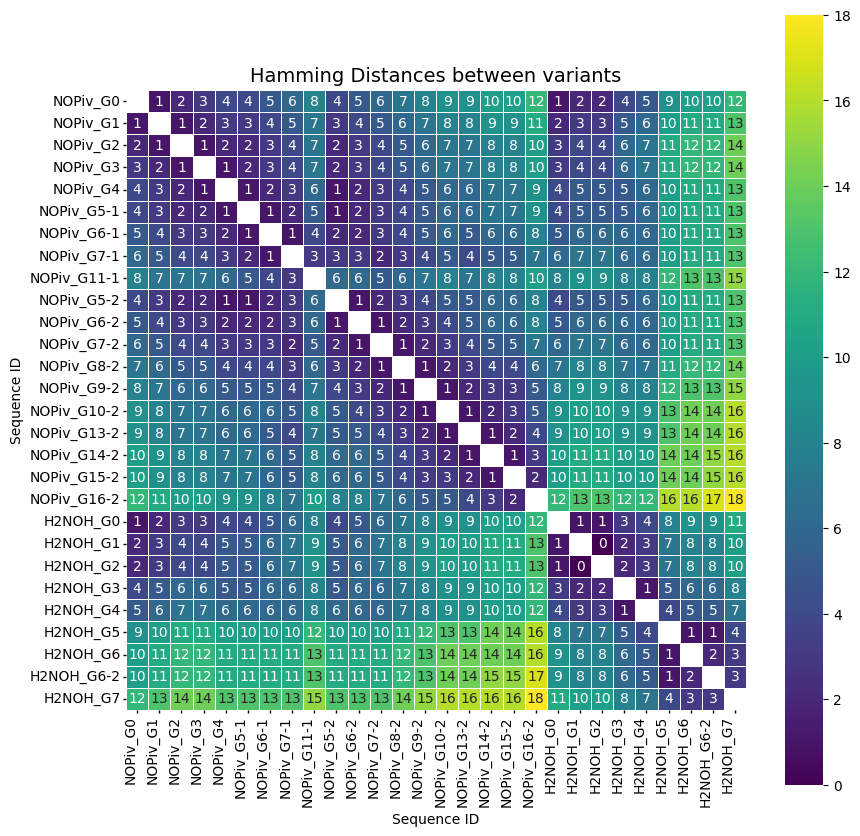

In [5]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_df, annot=True, fmt=".0f", cmap="viridis", cbar=True, square=True, ax=ax1,
            linewidths=0.5, linecolor="white")
ax1.set_title(f"Hamming Distances between variants", fontsize=14)
ax1.set_xlabel("Sequence ID")
ax1.set_ylabel("Sequence ID")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax1 = clean_plt(ax1)
plt.savefig(f'{fig_dir}heatmap_levenshtein_lineage.png', dpi=300)
plt.savefig(f'{fig_dir}heatmap_levenshtein_lineage.svg')

# Look at the sequence function data and make heatmaps across the landscape

In [36]:
nopiv1_camp = ['NOPiv_G7-1']
nopiv2_camp = ['NOPiv_G13-2', 'NOPiv_G9-2', 'NOPiv_G10-2']
h2noh_camp  = ['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

def make_heatmap(df, label, remove_empty=False, vmin=-10, vmax=10, cmap='RdBu_r', figsize=(18, 4), column='Area plate standard norm', variants_to_highlight=None):
    # Now we want the actual number of positions we can do this by computing all numbers
    positions = []
    position_dict = defaultdict(list)
    position_to_value = defaultdict(dict)
    for subs, value in df[['amino_acid_substitutions', column]].values:
        for pos in subs.split('_'):
            # Only keep those that weren't retained
            positions.append(int(pos[1:-1]))
            position_dict[int(pos[1:-1])].append(pos[-1])
            if position_to_value[int(pos[1:-1])].get(pos[-1]):
                value = float(value)
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
            else:
                position_to_value[int(pos[1:-1])][pos[-1]] = []
                value = float(value)
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
    position_to_max_value = defaultdict(dict)
    for position, aas in position_to_value.items():
        for aa in aas:
            values = position_to_value.get(position).get(aa)
            position_to_max_value[position][aa] = float(np.nanmax(values))

    # Create an empty DataFrame for all letters and numbers
    letters = list("RHKDESTNQCGPAVILMFYW*")
    if remove_empty:
        numbers = list(position_dict.keys())
        numbers.sort()
    else:
        numbers = list(range(0, 204))  # 0 to 100
    
    # Initialize a DataFrame with zeros
    data = pd.DataFrame(0.0, index=letters, columns=numbers)
    
    highlight_cells = [] 

    # Fill the DataFrame with counts
    x = 0
    for number, letters_list in position_to_value.items():
        y = 0
        counts = Counter(letters_list)
        for letter, count in counts.items():
            data.at[letter, number] = float(np.nanmax(count)) #np.log(count)
            if variants_to_highlight:
                variant_str = f'{number}{letter}'
                if variant_str in variants_to_highlight:
                    row_idx = data.index.get_loc(letter)
                    col_idx = data.columns.get_loc(number)
                    highlight_cells.append((row_idx, col_idx))
            y += 1
        x += 1
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, cmap=cmap, vmin=vmin, vmax=vmax, linewidths=.25, cbar_kws={'label': column})
    if variants_to_highlight:        
        for (row, col) in highlight_cells:
            rect = Rectangle((col, row), 1, 1, fill=False, edgecolor='yellow', linewidth=2)
            ax.add_patch(rect)
            
    plt.xlabel("Residue position")
    plt.ylabel("Aminoacid substitution")
    plt.title(f"Positions explored across {label}")
    ax.set_yticks([y + 0.5 for y in range(data.shape[0])])
    ax.set_yticklabels(data.index, rotation=0)  # adjust rotation as needed
    if not remove_empty:
        xticks = range(0, data.shape[1], 5)
        ax.set_xticks([x + 0.5 for x in xticks])
        ax.set_xticklabels(data.columns[xticks], rotation=90)  # Adjust rotation for readability
    else:
        ax.set_xticks([x + 0.5 for x in range(data.shape[1])])
        ax.set_xticklabels(data.columns, rotation=90)  # adjust rotation as needed
    plt.tight_layout()
    plt.savefig(f'{fig_dir}heatmap_{label}_positions_area_norm.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{fig_dir}heatmap_{label}_positions_area_norm.svg')

    plt.show()

# Read in the DF and then remove variants that we don't want to plot

In [7]:
nn_df = pd.read_csv(f'{output_dir}LevSeq_CombinedDF_pdt_filtered.csv')
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions
0,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.581206,1.461312,294944.247785,234101.734160,1
1,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.703650,0.441502,294944.247785,234101.734160,1
2,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.867991,0.311062,294944.247785,234101.734160,1
3,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,W62S,A10,0.964103,39.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,8.0,D4F-A10,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,100422.7253,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.830927,0.340480,294944.247785,234101.734160,1
4,1,G12-2-M86C-W62X,T184G_G185T_A256T_T257G_G258T,W62V,A11,0.937931,29.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,9.0,D4F-A11,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,80172.7978,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.917428,0.271824,294944.247785,234101.734160,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,40,ep-P8,C5T,T2I,G4,0.846154,78.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,77.0,D6B-G4,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,331518.9205,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,-2.085983,0.756616,438160.254575,51122.815929,1
3599,40,ep-P8,C488T,S163L,G5,0.960000,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,78.0,D6B-G5,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,291902.5909,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,-2.860908,0.666201,438160.254575,51122.815929,1
3600,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87.0,D6B-H2,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,-6.591840,0.230890,438160.254575,51122.815929,2
3601,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93.0,D6B-H8,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6,-7.047915,0.177677,438160.254575,51122.815929,2


# Plot various heatmaps

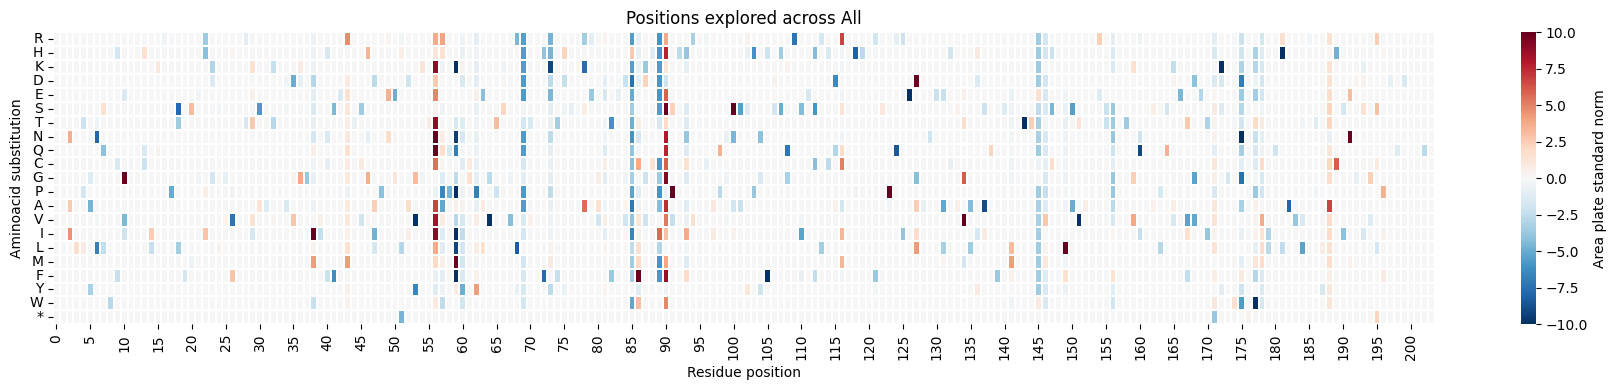

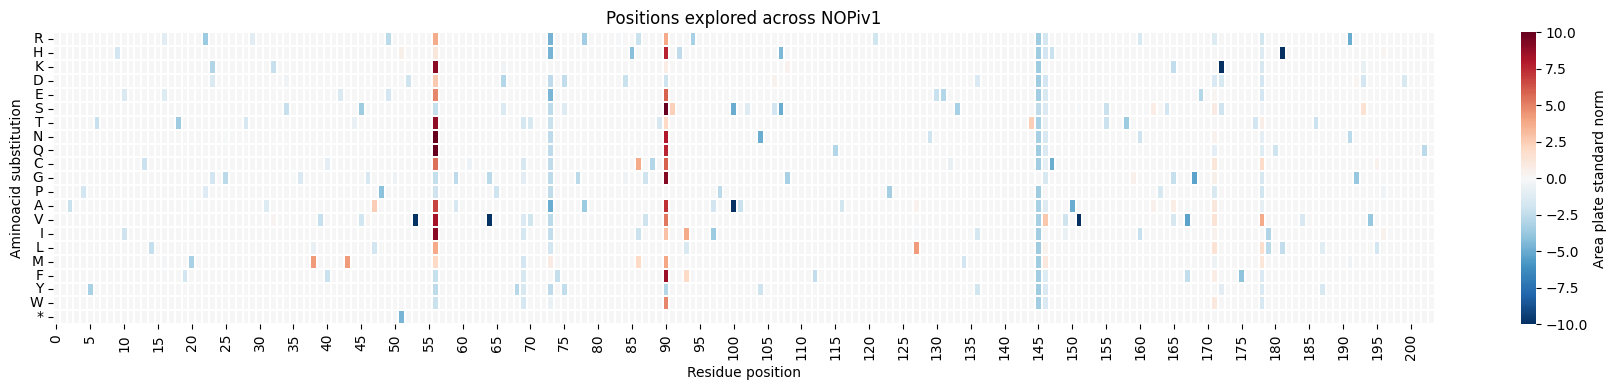

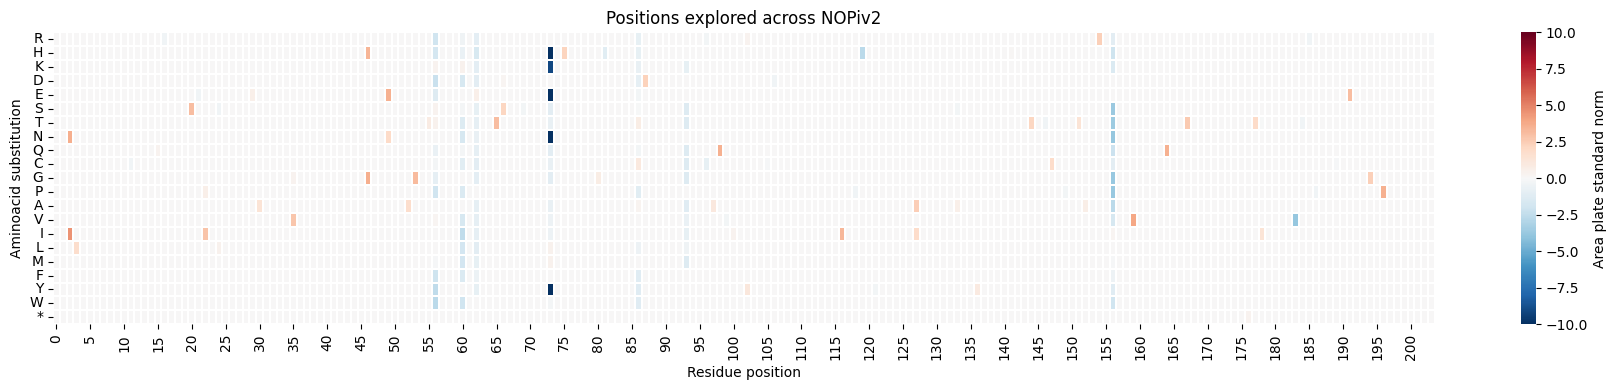

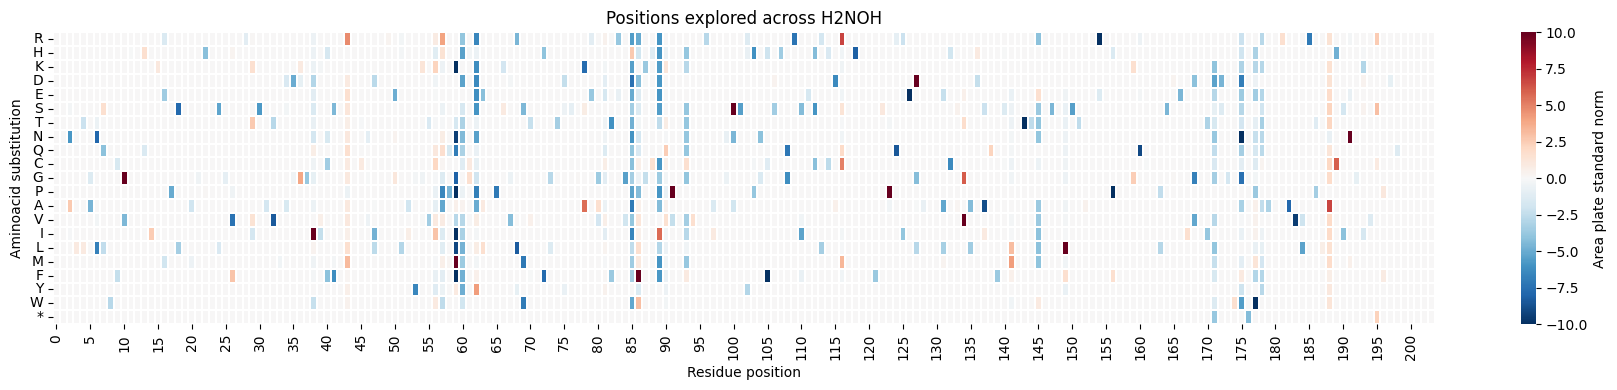

In [8]:
make_heatmap(nn_df, 'All') # Everything
make_heatmap(nn_df[nn_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1') # only the ones in those specific campaigns
make_heatmap(nn_df[nn_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2')
make_heatmap(nn_df[nn_df['campaign_name'].isin(h2noh_camp)], 'H2NOH')

# Now we only want to plot positives

For this, let's change the colour and also the ranges for the data.

In [9]:
h2noh_substitutions # We can see that these sites were not observed in the LevSeq analysis 61R (G5) 134A (G2) 167V (G5) 174L (G5) 20240603-JR-SSM

['2A',
 '29T',
 '59M',
 '61R',
 '62Y',
 '86F',
 '116R',
 '134A',
 '149L',
 '167V',
 '174L']

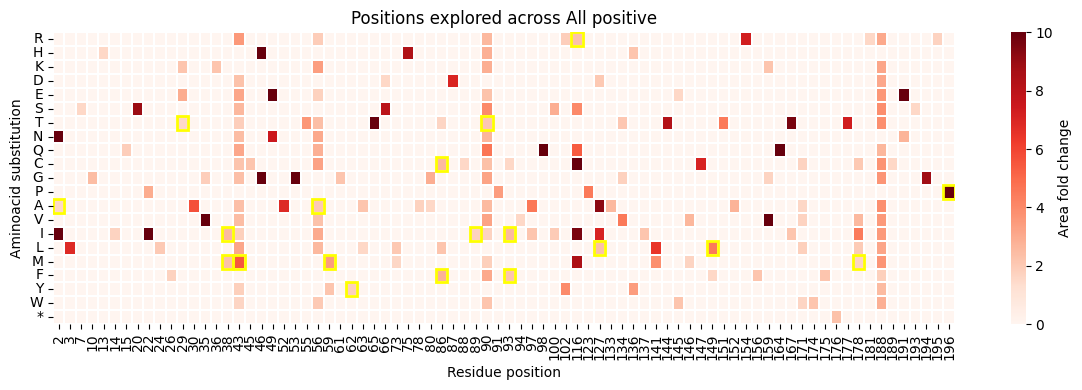

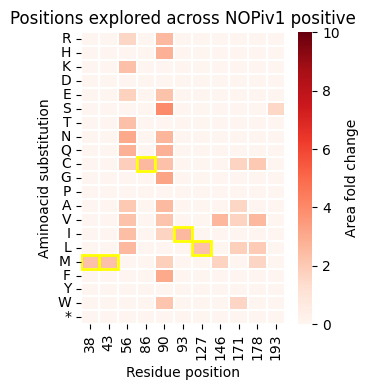

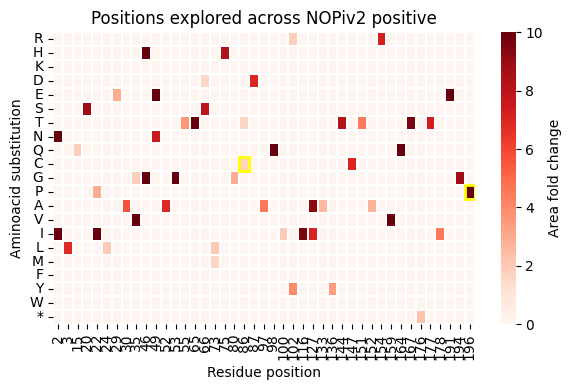

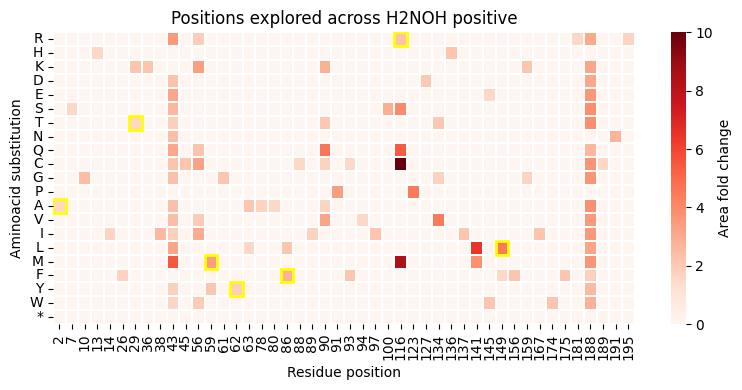

In [38]:
positive_df = nn_df[nn_df['Area fold change'] > 1.5]
make_heatmap(positive_df, 'All positive', vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(12, 4), column='Area fold change', 
            variants_to_highlight=nopiv1_substitutions + h2noh_substitutions + nopiv2_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1 positive', vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(3.5, 4), 
             column='Area fold change', variants_to_highlight=nopiv1_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2 positive',  vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(6, 4), 
             column='Area fold change', variants_to_highlight=nopiv2_substitutions)
make_heatmap(positive_df[positive_df['campaign_name'].isin(h2noh_camp)], 'H2NOH positive',  vmin=0, vmax=10, cmap='Reds', remove_empty=True, figsize=(8, 4), column='Area fold change' , 
             variants_to_highlight=h2noh_substitutions)

# Do the same but for negative data

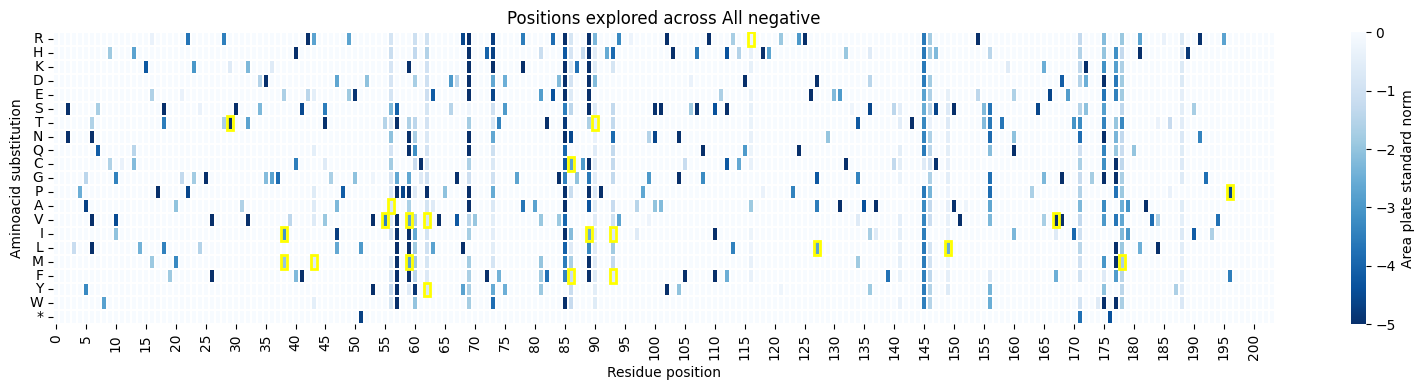

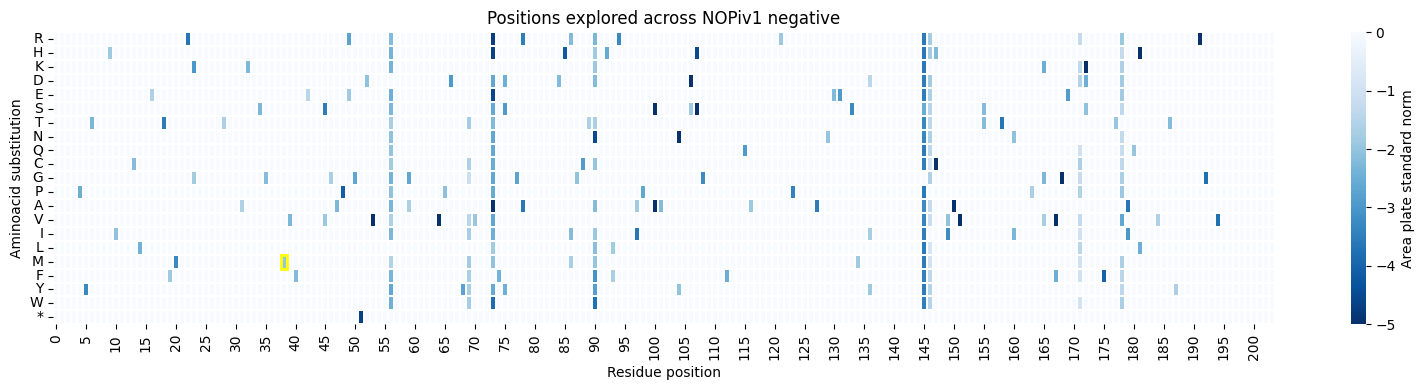

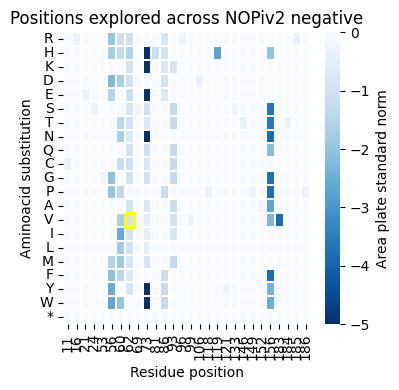

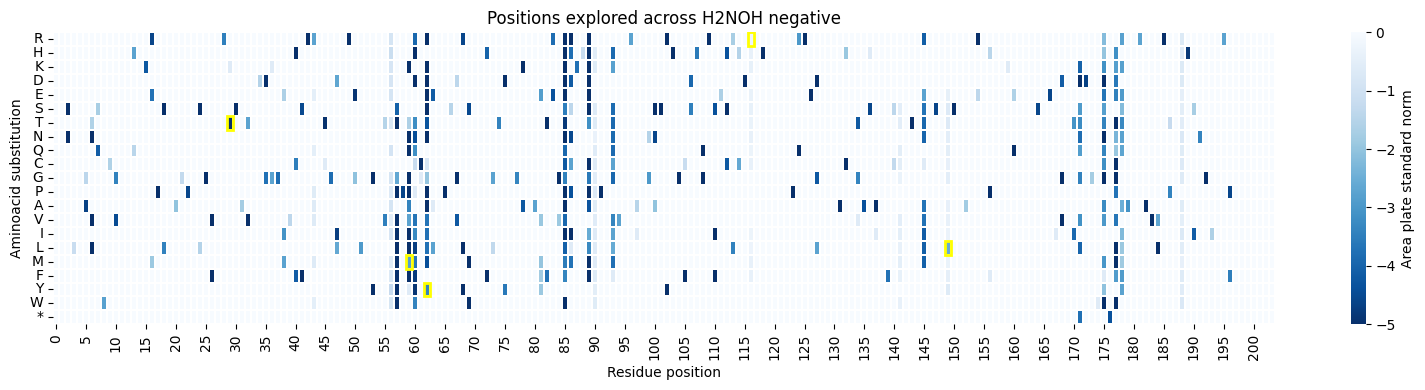

In [39]:
negative_df = nn_df[nn_df['Area fold change'] < 0.5]
vmin = -5
vmax = 0

make_heatmap(negative_df, 'All negative', vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4), variants_to_highlight=nopiv1_substitutions + h2noh_substitutions + nopiv2_substitutions)
make_heatmap(negative_df[negative_df['campaign_name'].isin(nopiv1_camp)], 'NOPiv1 negative', vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4), variants_to_highlight=nopiv1_substitutions)
make_heatmap(negative_df[negative_df['campaign_name'].isin(nopiv2_camp)], 'NOPiv2 negative',  vmin=vmin, vmax=vmax, cmap='Blues_r', remove_empty=True, figsize=(4, 4), variants_to_highlight=nopiv2_substitutions)
make_heatmap(negative_df[negative_df['campaign_name'].isin(h2noh_camp)], 'H2NOH negative',  vmin=vmin, vmax=vmax, cmap='Blues_r', figsize=(16, 4), variants_to_highlight=h2noh_substitutions)

# Next look at the combinations of mutations in the H2NOH campaign

We want to investigate the possible "missed" oppurtunities. 

- What we can do is look at which mutations conferred good activity and then see if they have occured with any others

- Note for visualizations we remove any positions which have already been "finalized"

In [40]:
h2noh_camp

['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

In [12]:
# Filter to only h2noh
positive_df = positive_df[positive_df['campaign_name'].isin(h2noh_camp)]

In [13]:
positive_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L                    57
A134V_I149L              15
V116R                    13
V38I_I149L               12
K43M                     10
                         ..
D10G_A91P                 1
V38I_A59M_A134G_K191N     1
A59M_I149L_K191N          1
V89I_T100S_I149L          1
A134T                     1
Name: count, Length: 101, dtype: int64

In [14]:
positive_df['# substitutions'] = [len(pos.split('_')) for pos in positive_df['amino_acid_substitutions'].values]

In [81]:
mutli_subs = positive_df[positive_df['# substitutions'] > 1]
mutli_subs = mutli_subs[mutli_subs['Area plate standard norm'] > 2]
len(mutli_subs['amino_acid_substitutions'].value_counts())

44

In [78]:
positive_potential_positions = []
duplicates = []
for aa in set(mutli_subs['amino_acid_substitutions'].values):
    for p in aa.split('_'):
        if int(p[1:-1]) in positive_potential_positions:
            duplicates.append(int(p[1:-1]))
        positive_potential_positions.append(int(p[1:-1]))
len(set(positive_potential_positions))

34

In [76]:
len(set(duplicates))

15

In [77]:
set(h2noh_positions) & set(duplicates)

{2, 59, 62, 116, 134, 149}

In [82]:
set([x for x in duplicates if x not in h2noh_positions])

{10, 38, 43, 89, 90, 91, 100, 127, 191}

In [80]:
set(positive_potential_positions) & set(h2noh_positions)

{2, 29, 59, 62, 86, 116, 134, 149}

# Visualize these potentially epistatic sites

Here we want to visualize these potentially epistatic sites to see if as combinations they performed better than in isolation.



In [16]:
final_variant = lineage_df[lineage_df['name'] == 'H2NOH_G7']['AA'].values[0]

In [17]:
mutli_subs_dedup = mutli_subs.drop_duplicates(subset=['aa_sequence'])
mutli_subs_dedup['name'] = [f'{campaign_name.replace("_", "-")}_{v}' for campaign_name, v in mutli_subs_dedup[['campaign_name', 'amino_acid_substitutions']].values]
h2noh_substitutions_full = get_hamming(lineage_df, 'H2NOH_G0', 'H2NOH_G7')

# Step 1: Write initial FASTA
fasta_path = f'{output_dir}h2noh_multisubs_raw.fa'
with open(fasta_path, 'w') as fout:
    fout.write(f'>H2NOH-G7_{"_".join(h2noh_substitutions_full)}\n{final_variant}\n')
    for name, aa_seq in mutli_subs_dedup[['name', 'aa_sequence']].values:
        # if len(name.split('_')) > 5:
        #     name = '_'.join(name.split('_')[:4]) + '...'
        aa_seq = aa_seq.replace('*', '')
        fout.write(f'>{name}\n{aa_seq}\n')


--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_38281/3224777426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutli_subs_dedup['name'] = [f'{campaign_name.replace("_", "-")}_{v}' for campaign_name, v in mutli_subs_dedup[['campaign_name', 'amino_acid_substitutions']].values]


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_38281/2763591743.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_labels = df_labels.applymap(lambda x: INT_TO_AA.get(x, '?'))


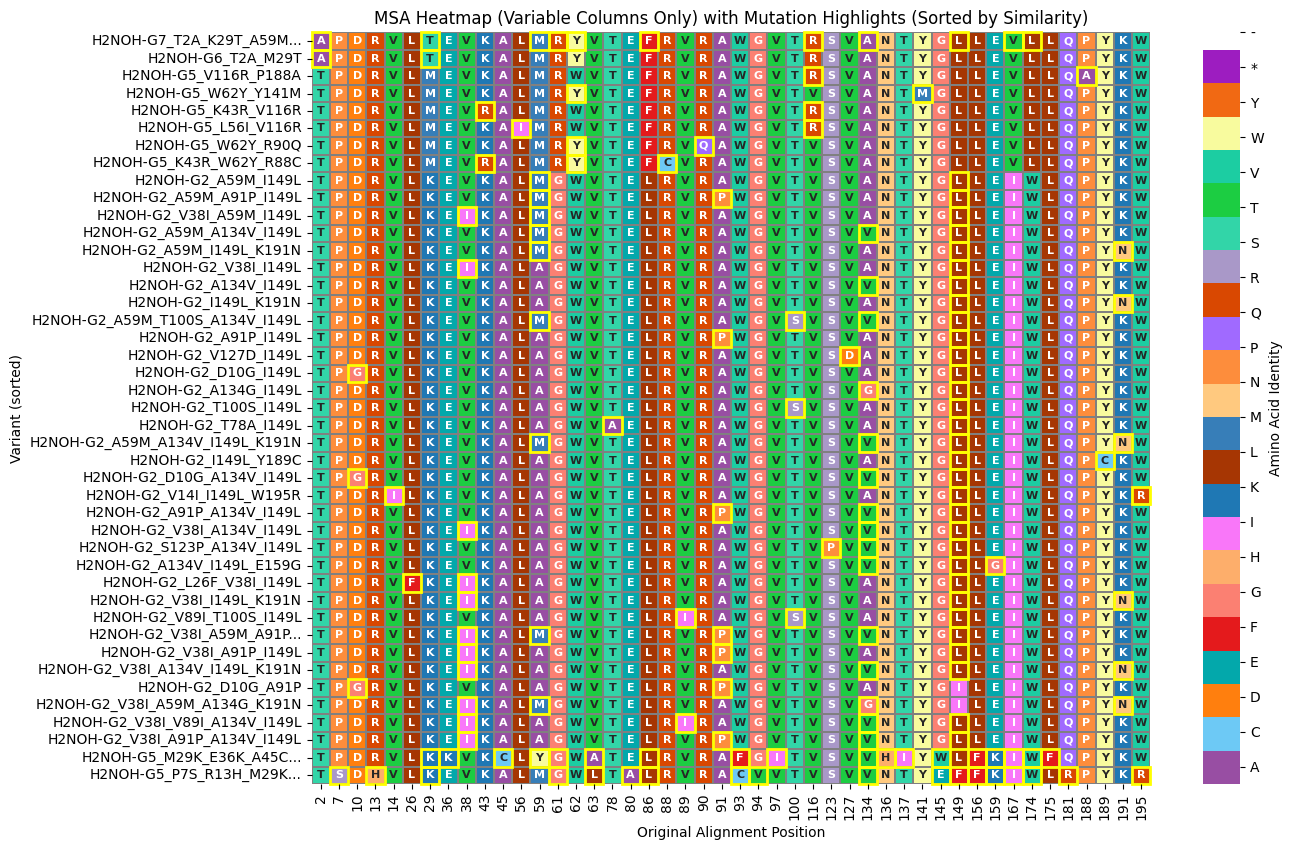

In [18]:
# Helper functios

# Collect mutation positions per record based on record.id
def extract_mut_positions(record_id):
    # Example ID: 'H2NOH_G7_M27C_K45R' etc.
    # Split by '_' and find parts matching mutation pattern: Letter-Number-Letter
    record_id = record_id.strip()
    parts = record_id.split('_')
    positions = set()
    for part in parts[1:]:
        if len(part) > 2:
            pos = int(part[1:-1])
            positions.add(pos)
    return positions

    
# Load the alignment
alignment = AlignIO.read(f'{output_dir}h2noh_multisubs_raw.fa', 'fasta')

# Amino acid mapping
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY*-")
AA_TO_INT = {aa: i for i, aa in enumerate(AA_LIST)}
INT_TO_AA = {i: aa for aa, i in AA_TO_INT.items()}
palette = ['#984ea3',
           '#6dc9f5',
           '#ff7f0e',
           '#03a8ab',
           '#e41a1c',
           '#fb8072',
           '#fdae6b',
           '#f977f9',
           '#1f78b4',
           '#a63603',
           '#377eb8',
           '#ffc97f',
           '#fd8d3c',
           '#a06aff',
           '#d94801',
           '#a998c8',
           '#32d5a8',
           '#1ccd42',
           '#1ccda2',
           '#f8fb9e',
           '#f16913',
           '#9d1dc0']

heatmap_data = []
row_labels = []


mutation_positions_per_row = []

for record in alignment:
    name = record.id
    if len(name.split('_')) > 5:
        name = '_'.join(name.split('_')[:4]) + '...'
    row_labels.append(name)
    heatmap_data.append([AA_TO_INT.get(res, -1) for res in str(record.seq)])
    mutation_positions_per_row.append(extract_mut_positions(record.id))

heatmap_array = np.array(heatmap_data)
heatmap_array = np.array(heatmap_data)

# Identify variant columns
variant_columns = []
for i in range(heatmap_array.shape[1]):
    if len(set(heatmap_array[:, i])) > 1:
        variant_columns.append(i)

filtered_array = heatmap_array[:, variant_columns]
column_labels = [i + 1 for i in variant_columns]  # 1-based positions as int

df_heatmap = pd.DataFrame(filtered_array, index=row_labels, columns=column_labels)



# Reference sequence (first row)
ref_seq = df_heatmap.iloc[0].values

# Compute distances for all rows
distances = []
for idx in range(df_heatmap.shape[0]):
    seq = df_heatmap.iloc[idx].values
    dist = hamming_distance(ref_seq, seq)
    distances.append((df_heatmap.index[idx], dist))

# Sort by distance ascending
distances_sorted = sorted(distances, key=lambda x: x[1])
sorted_labels = [label for label, dist in distances_sorted]

# Reorder dataframes and mutation lists accordingly
df_heatmap = df_heatmap.loc[sorted_labels]
mutation_positions_per_row_sorted = [mutation_positions_per_row[row_labels.index(lbl)] for lbl in sorted_labels]

# Recreate labels for annotations
df_labels = df_heatmap.copy()
df_labels = df_labels.applymap(lambda x: INT_TO_AA.get(x, '?'))

fig, ax = plt.subplots(figsize=(len(df_heatmap.columns) * 0.3, len(df_heatmap.index) * 0.2))

sns.heatmap(
    df_heatmap,
    cmap=palette,
    cbar=True,
    linewidths=0.05,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True,
    vmin=0,
    vmax=len(AA_LIST) - 1,
    annot=df_labels,
    fmt='s',
    annot_kws={"fontsize": 8, "weight": "bold"},
    ax=ax
)

# Highlight mutated cells with rectangles
for row_idx, mut_positions in enumerate(mutation_positions_per_row_sorted):
    for col_idx, pos in enumerate(column_labels):
        if pos in mut_positions:
            ax.add_patch(plt.Rectangle(
                (col_idx, row_idx), 1, 1,
                fill=False,
                edgecolor='yellow',
                lw=2,
                clip_on=False
            ))

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(np.arange(len(AA_LIST)) + 0.5)
colorbar.set_ticklabels(AA_LIST)
colorbar.set_label("Amino Acid Identity")

plt.title("MSA Heatmap (Variable Columns Only) with Mutation Highlights (Sorted by Similarity)")
plt.xlabel("Original Alignment Position")
plt.ylabel("Variant (sorted)")
plt.tight_layout()

plt.savefig(f"{fig_dir}msa_h2noh_multisubs_heatmap_variable_grouped_highlighted_sorted.png", dpi=300)
plt.savefig(f"{fig_dir}msa_h2noh_multisubs_heatmap_variable_grouped_highlighted_sorted.svg")

# Visualize the joint and indiviudal substitutions across the plate

- Here we want to visualize a scatter plot across the dataset so that we can see what mutations co-occur with others.

In [19]:
df = positive_df[positive_df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area plate standard norm']].values:
    positions = pos.split('_')
    for i in positions:
        rows.append([pos, int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'position', 'aa', 'value', '# substiutions'])
vis_df = vis_df.sort_values(by='position')

In [20]:
h2noh_positions = [int(x[:-1]) for x in h2noh_substitutions]

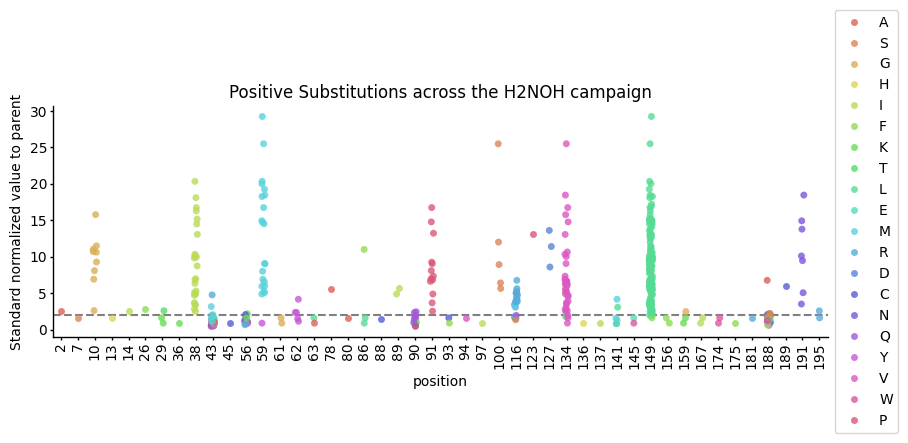

In [21]:
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
plt.figure(figsize=(10, 3))
ax = sns.stripplot(vis_df, x='position', y='value', hue='aa', palette='hls', alpha=0.8)
clean_plt(ax)
plt.axhline(y=2, color='grey', linestyle='--')
plt.ylabel('Standard normalized value to parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Positive Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign'.replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign'.replace(' ', '_') + '.svg', bbox_inches='tight')

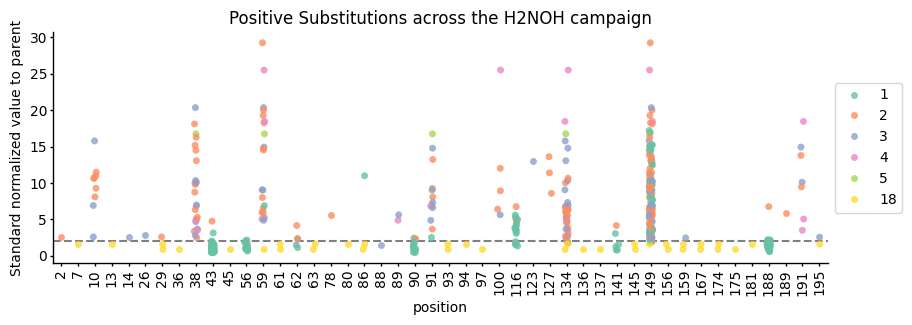

In [22]:
plt.figure(figsize=(10, 3))
ax = sns.stripplot(vis_df, x='position', y='value', hue='# substiutions', alpha=0.8, palette='Set2')
clean_plt(ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=2, color='grey', linestyle='--')
plt.ylabel('Standard normalized value to parent')
plt.title('Positive Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.svg', dpi=300, bbox_inches='tight')

In [23]:
# Do the same but for the negative so we can see whether we have negative data also for these positions
df = negative_df[negative_df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area plate standard norm']].values:
    for i in pos.split('_'):
        rows.append([pos, int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
negative_vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'position', 'aa', 'value', '# substiutions'])
negative_vis_df = negative_vis_df.sort_values(by='position')
positive_positions = [int(p) for p in positive_positions]
negative_positions = [int(i) for i in negative_vis_df['position'].values]
negative_vis_df['position'] = negative_positions
negative_vis_df = negative_vis_df.sort_values(by='position')
negative_vis_df = negative_vis_df[negative_vis_df['position'].isin(positive_positions)]
negative_vis_df

,amino_acid_substitutions,position,aa,value,# substiutions
1113,T2N_F24L_R61C,2,N,-5.841436,3
1104,T2S_K125R,2,S,-5.410275,2
147,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,7,S,-5.652944,18
126,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,7,S,-5.512855,17
167,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,7,S,-2.738083,18
...,...,...,...,...,...
647,A59M_V127D_L156P_K191N,191,N,-10.292881,4
184,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,195,R,-2.738083,18
1616,D10G_M29T_Y40C_K42R_W195R,195,R,-7.320881,5
164,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,195,R,-5.652944,18


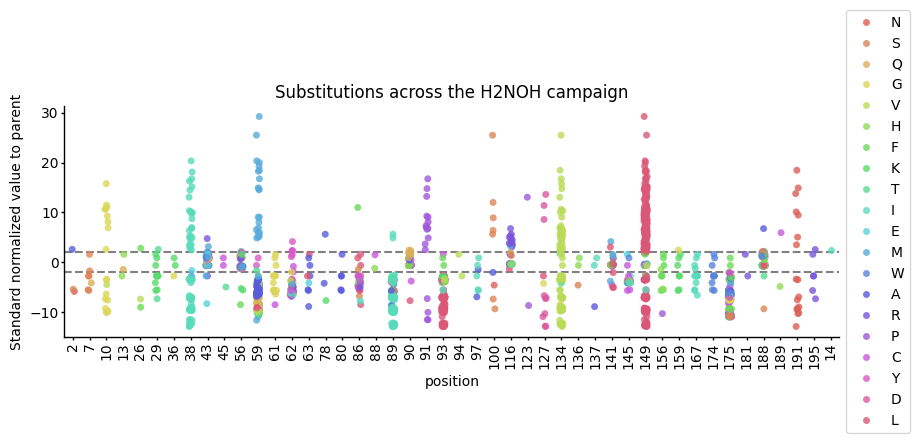

In [24]:
vis_df = vis_df[~vis_df['position'].isin(h2noh_positions)]
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
negative_vis_df['position'] = [str(int(p)) for p in negative_vis_df['position'].values]
df = pd.concat([negative_vis_df, vis_df])
plt.figure(figsize=(10, 3))
ax = sns.stripplot(df, x='position', y='value', hue='aa', alpha=0.8, palette='hls')
plt.ylabel('Standard normalized value to parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

clean_plt(ax)
plt.axhline(y=-2, color='grey', linestyle='--')
plt.axhline(y=2, color='grey', linestyle='--')
plt.title('Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Substitutions across the H2NOH campaign - aa'.replace(' ', '_') + '.png', dpi=300)
plt.savefig(f'{fig_dir}stripplot_Substitutions across the H2NOH campaign - aa'.replace(' ', '_') + '.svg')

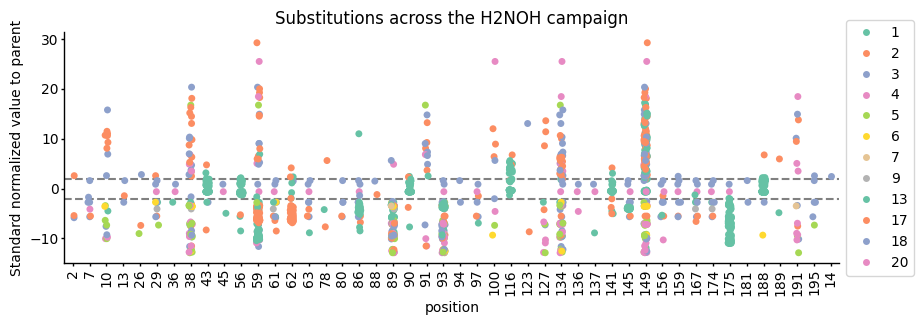

In [25]:
vis_df = vis_df[~vis_df['position'].isin(h2noh_positions)]
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
negative_vis_df['position'] = [str(int(p)) for p in negative_vis_df['position'].values]
df = pd.concat([negative_vis_df, vis_df])
plt.figure(figsize=(10, 3))
ax = sns.stripplot(df, x='position', y='value', hue='# substiutions', palette='Set2')
plt.ylabel('Standard normalized value to parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=-2, color='grey', linestyle='--')
plt.axhline(y=2, color='grey', linestyle='--')

clean_plt(ax)
plt.title('Substitutions across the H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.png', dpi=300)

In [26]:
h2noh_substitutions # We can see that these sites were not observed in the LevSeq analysis 61R (G5) 134A (G2) 167V (G5) 174L (G5) 20240603-JR-SSM

['2A',
 '29T',
 '59M',
 '61R',
 '62Y',
 '86F',
 '116R',
 '134A',
 '149L',
 '167V',
 '174L']

# Based on these visualizations we can make filter to positions we're interested in testing in the lab (for epistasis)

1. Is there a 1.5 standard norm increase AND a 1.5 fold change above parent
2. Is there also a -1.5 standard norm increase AND a 0.5 fold change compared to parent
3. Which mutations positively contribute and which ones negatively?

In [27]:
positions_meeting_criteria = []
for position, grp in df.groupby('position'):
    value = grp['value'].values
    if min(value) < -2 and max(value) > 2:
        positions_meeting_criteria.append(position)

epistatic_df = df[df['position'].isin(positions_meeting_criteria)]
epistatic_df

,amino_acid_substitutions,position,aa,value,# substiutions
1113,T2N_F24L_R61C,2,N,-5.841436,3
1104,T2S_K125R,2,S,-5.410275,2
264,D10G_V38I_V89I_W93L_I149L,10,G,-3.416336,5
584,D10G_A91P_G126E_I149L,10,G,-10.041101,4
610,D10G_V89I_W93L_I149L_K154R,10,G,-10.043864,5
...,...,...,...,...,...
282,I149L_K191N,191,N,9.461095,2
278,V38I_A59M_A134G_K191N,191,N,5.052500,4
355,A59M_A134V_I149L_K191N,191,N,18.459046,4
152,V14I_I149L_W195R,195,R,2.565493,3


In [42]:
len(epistatic_df['amino_acid_substitutions'].unique())

282

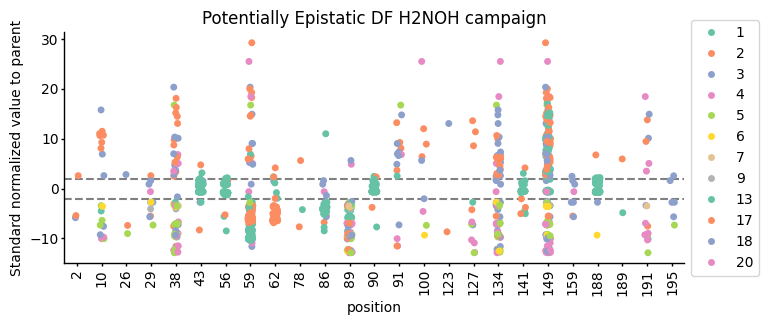

In [28]:
plt.figure(figsize=(8, 3))
ax = sns.stripplot(epistatic_df, x='position', y='value', hue='# substiutions', palette='Set2')
plt.ylabel('Standard normalized value to parent')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=-2, color='grey', linestyle='--')
plt.axhline(y=2, color='grey', linestyle='--')

clean_plt(ax)
plt.title('Potentially Epistatic DF H2NOH campaign')
plt.savefig(f'{fig_dir}stripplot_EpistaticDF'.replace(' ', '_') + '.png', dpi=300)

In [43]:
positions_of_interest = set(epistatic_df['position'].values)
positions_of_interest

{'10',
 '100',
 '123',
 '127',
 '134',
 '141',
 '149',
 '159',
 '188',
 '189',
 '191',
 '195',
 '2',
 '26',
 '29',
 '38',
 '43',
 '56',
 '59',
 '62',
 '78',
 '86',
 '89',
 '90',
 '91'}

# For each of these positions make a heatmap so we can see what other positions it was positive and negative with


In [30]:
# Helper functios

# Collect mutation positions per record based on record.id
def extract_mut_positions(record_id):
    # Example ID: 'H2NOH_G7_M27C_K45R' etc.
    # Split by '_' and find parts matching mutation pattern: Letter-Number-Letter
    record_id = record_id.strip()
    parts = record_id.split('_')
    positions = set()
    for part in parts[1:]:
        if len(part) > 2:
            pos = int(part[1:-1])
            positions.add(pos)
    return positions
# Sort rows by similarity (Hamming distance) to first row
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum(a != b for a, b in zip(seq1, seq2))
    
# Load the alignment
def alignment_heatmap(filename, title):
    alignment = AlignIO.read(filename, 'fasta')

    # Amino acid mapping
    AA_LIST = list("ACDEFGHIKLMNPQRSTVWY*-")
    AA_TO_INT = {aa: i for i, aa in enumerate(AA_LIST)}
    INT_TO_AA = {i: aa for aa, i in AA_TO_INT.items()}
    palette = ['#984ea3',
               '#6dc9f5',
               '#ff7f0e',
               '#03a8ab',
               '#e41a1c',
               '#fb8072',
               '#fdae6b',
               '#f977f9',
               '#1f78b4',
               '#a63603',
               '#377eb8',
               '#ffc97f',
               '#fd8d3c',
               '#a06aff',
               '#d94801',
               '#a998c8',
               '#32d5a8',
               '#1ccd42',
               '#1ccda2',
               '#f8fb9e',
               '#f16913',
               '#9d1dc0']
    
    heatmap_data = []
    row_labels = []
    
    
    mutation_positions_per_row = []
    
    for record in alignment:
        name = record.id
        if len(name.split('_')) > 5:
            name = '_'.join(name.split('_')[:4]) + '...'
        row_labels.append(name)
        heatmap_data.append([AA_TO_INT.get(res, -1) for res in str(record.seq)])
        mutation_positions_per_row.append(extract_mut_positions(record.id))
    
    heatmap_array = np.array(heatmap_data)
    heatmap_array = np.array(heatmap_data)
    
    # Identify variant columns
    variant_columns = []
    for i in range(heatmap_array.shape[1]):
        if len(set(heatmap_array[:, i])) > 1:
            variant_columns.append(i)
    
    filtered_array = heatmap_array[:, variant_columns]
    column_labels = [i + 1 for i in variant_columns]  # 1-based positions as int
    
    df_heatmap = pd.DataFrame(filtered_array, index=row_labels, columns=column_labels)
    
    # Reference sequence (first row)
    ref_seq = df_heatmap.iloc[0].values
    
    # Compute distances for all rows
    distances = []
    for idx in range(df_heatmap.shape[0]):
        seq = df_heatmap.iloc[idx].values
        dist = hamming_distance(ref_seq, seq)
        distances.append((df_heatmap.index[idx], dist))
    
    # Sort by distance ascending
    distances_sorted = sorted(distances, key=lambda x: x[1])
    sorted_labels = [label for label, dist in distances_sorted]
    
    # Reorder dataframes and mutation lists accordingly
    df_heatmap = df_heatmap.loc[sorted_labels]
    mutation_positions_per_row_sorted = [mutation_positions_per_row[row_labels.index(lbl)] for lbl in sorted_labels]
    
    # Recreate labels for annotations
    df_labels = df_heatmap.copy()
    df_labels = df_labels.applymap(lambda x: INT_TO_AA.get(x, '?'))
    
    fig, ax = plt.subplots(figsize=(len(df_heatmap.columns) * 0.3, len(df_heatmap.index) * 0.2))
    
    sns.heatmap(
        df_heatmap,
        cmap=palette,
        cbar=True,
        linewidths=0.05,
        linecolor='gray',
        xticklabels=True,
        yticklabels=True,
        vmin=0,
        vmax=len(AA_LIST) - 1,
        annot=df_labels,
        fmt='s',
        annot_kws={"fontsize": 8, "weight": "bold"},
        ax=ax
    )
    
    # Highlight mutated cells with rectangles
    for row_idx, mut_positions in enumerate(mutation_positions_per_row_sorted):
        for col_idx, pos in enumerate(column_labels):
            if pos in mut_positions:
                ax.add_patch(plt.Rectangle(
                    (col_idx, row_idx), 1, 1,
                    fill=False,
                    edgecolor='yellow',
                    lw=2,
                    clip_on=False
                ))
    
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks(np.arange(len(AA_LIST)) + 0.5)
    colorbar.set_ticklabels(AA_LIST)
    colorbar.set_label("Amino Acid Identity")
    
    plt.title(title)
    plt.xlabel("Original Alignment Position")
    plt.ylabel("Variant (sorted)")
    plt.tight_layout()
    
    plt.savefig(f"{fig_dir}msa_{title.replace(' ', '')}.png", dpi=300)
    plt.savefig(f"{fig_dir}msa__{title.replace(' ', '')}.svg")
    plt.show()

# Just write out the novel positions

In [31]:
# Now let's remove any which don't have at least one novel substitution
# i.e. it only has substitutions from the final 
novel_positions = []
rows = []
h2noh_df = nn_df[nn_df['campaign_name'].isin(h2noh_camp)]
for pos, name, seq, value in h2noh_df[['amino_acid_substitutions', 'campaign_name', 'aa_sequence', 'Area plate standard norm']].values:
    novel = False
    for p in pos.split('_'):
        if int(p[1:-1]) not in h2noh_substitutions:
            novel = True
        if p[1:-1] in positions_of_interest:
            label = ''
            if value > 2.0:
                label = '+ve-' 
            elif value < -2.0:
                label = '-ve-' 
            seq = seq.replace('*', '')
            if len(seq) == 203:
                rows.append([p[1:-1], f'{label}{name}_{pos}', value, name, pos, seq])
    novel_positions.append(novel)
h2noh_df['novel_position'] = novel_positions
novel_df = h2noh_df[h2noh_df['novel_position'] == True]
epistatic_all_df = pd.DataFrame(rows, columns=['position', 'name', 'Area plate standard norm', 'campaign_name', 'amino_acid_substitutions', 'aa_sequence'])
epistatic_all_df

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_38281/881462740.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2noh_df['novel_position'] = novel_positions


,position,name,Area plate standard norm,campaign_name,amino_acid_substitutions,aa_sequence
0,62,H2NOH_G5_W62G_P81M,-1.973659,H2NOH_G5,W62G_P81M,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1,29,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
2,38,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
3,59,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
4,86,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
...,...,...,...,...,...,...
1793,2,-ve-H2NOH_G6_T2I_D104G,-4.100256,H2NOH_G6,T2I_D104G,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1794,90,-ve-H2NOH_G6_R90L,-7.693893,H2NOH_G6,R90L,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1795,29,H2NOH_G6_M29I,-1.743830,H2NOH_G6,M29I,MTPSDIPGYDYGRVEKSPITDLEFDLLKITVMLGEEDVMYLKKAAD...
1796,2,-ve-H2NOH_G6_T2I,-2.085983,H2NOH_G6,T2I,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...


In [32]:
len(final_variant)

203

In [33]:
for pos in epistatic_all_df['position'].unique():
    sub_df = epistatic_all_df[epistatic_all_df['position'] == pos]
    # Step 1: Write initial FASTA
    fasta_path = f'{output_dir}h2noh_{pos}.fa'
    with open(fasta_path, 'w') as fout:
        fout.write(f'>H2NOH-G7_{"_".join(h2noh_substitutions_full)}\n{final_variant}\n')
        for name, aa_seq in sub_df[['name', 'aa_sequence']].values:
            # if len(name.split('_')) > 5:
            #     name = '_'.join(name.split('_')[:4]) + '...'
            fout.write(f'>{name}\n{aa_seq}\n')
    #alignment_heatmap(fasta_path, f'Potentially epistatic seqs for position: {pos}')
    

In [35]:
epistatic_all_df# Make a heatmap of the positives and then the negatives so we can clearly 

,position,name,Area plate standard norm,campaign_name,amino_acid_substitutions,aa_sequence
0,62,H2NOH_G5_W62G_P81M,-1.973659,H2NOH_G5,W62G_P81M,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1,29,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
2,38,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
3,59,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
4,86,-ve-H2NOH_G5_M29K_V38I_M59V_R61G_F86C_V89I_W93...,-4.083397,H2NOH_G5,M29K_V38I_M59V_R61G_F86C_V89I_W93F_V167I_L174W,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...
...,...,...,...,...,...,...
1793,2,-ve-H2NOH_G6_T2I_D104G,-4.100256,H2NOH_G6,T2I_D104G,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1794,90,-ve-H2NOH_G6_R90L,-7.693893,H2NOH_G6,R90L,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
1795,29,H2NOH_G6_M29I,-1.743830,H2NOH_G6,M29I,MTPSDIPGYDYGRVEKSPITDLEFDLLKITVMLGEEDVMYLKKAAD...
1796,2,-ve-H2NOH_G6_T2I,-2.085983,H2NOH_G6,T2I,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...
